# Taller 3


**UNIVERSIDAD EXTERNADO DE COLOMBIA**

***Finanzas Computacionales***

Juan Pablo Pinzón

María Fernanda Diaz 

Fabio Ordoñez 

# **Taller Final**


La finalidad de este trabajo es demostrar la construcción aleatoria y optimización estadística de portafolios. Para ello se realizó un manejo de datos (financieros), estadísticas descriptivas y visualización. Por otro lado se construyó un portafolio de mínima varianza global de Markowitz, y se presento el grafico de pesos, y sus medidas de retornos esperada, y volatilidad.

Para la realización de este informe, inicialmente se escogieron tres acciones(MCD,JPM,V) con la información histórica para el periodo Enero 2016- Diciembre 2021 con una peridicidad mensual y se obtuvieron los precios históricos.

Al construir portafolios de inversión diversificados, son necesarias la utilización de técnicas como la construcción aleatoria y la optimización probabilística.

En la construcción aleatoria de un portafolio de inversión es necesario realizar diferentes combinaciones de activos. Las combinaciones pueden estar compuestas por diferentes clases de activos financieros (Bonos, títulos, acciones, entro otros). Cuando se realizan las combinaciones, se determina la mejor opción.

Si bien pueden existir diferentes factores que influyen a la hora de seleccionar los activos para construir un portafolio de inversión como por ejemplo el retorno esperado, o el riesgo, es importante que estos factores tengan un equilibro optimo.

La otra técnica, optimización probabilística de portafolios, es conocida por ser un método más avanzado. Esta técnica utiliza modelos para optimizar la asignación de los activos a escoger al portafolio, tiene en cuenta el rendimiento histórico, el riesgo, y si existe alguna correlación.

Al optimizar el portafolio se espera maximizar los retornos esperados del mismo, y a su vez minimizar el riesgo. Sin embargo, existen algunas limitaciones dados los datos atípicos, o eventos extraordinarios. Por ellos es importante la utilización de técnicas al momento de construir un portafolio de inversión.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cvxpy as cp
!pip install --quiet yfinance
import yfinance as yf
!pip install --quiet fitter
from fitter import Fitter, get_common_distributions, get_distributions
import statsmodels.api as sm
from statsmodels.tsa.api import acf, pacf, graphics
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings("ignore")

  Preparing metadata (setup.py) ... done


[*********************100%***********************]  1 of 1 completed


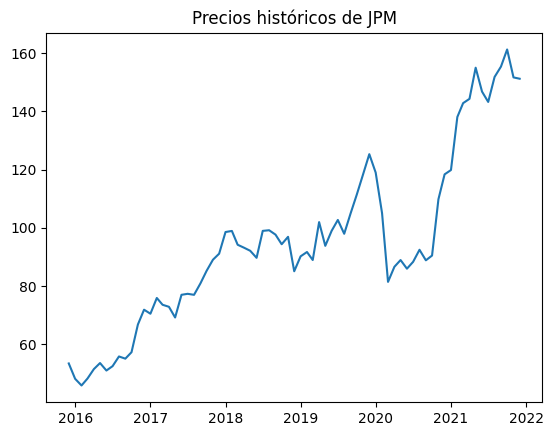

In [7]:
# Información histórica para acciones con periodicidad mensual
fechai = "2015-12-01"
fechaf = "2021-12-31"
periodicidad = "1Mo"
tickers= ["JPM"]
precios_jpm = yf.download(tickers,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos_jpm = np.log(precios_jpm/precios_jpm.shift(1)).dropna()
mu_jpm = retornos_jpm.mean()
sigma_jpm = retornos_jpm.std()
plt.plot(precios_jpm)
plt.title("Precios históricos de JPM")
plt.show()

Se evidencia que a lo largo de los años las acciones seleccionadas han presenciado un amento de los precios históricos.

In [8]:
precios_jpm.tail()

Date
2021-08-01    151.805695
2021-09-01    155.355270
2021-10-01    161.239578
2021-11-01    151.651077
2021-12-01    151.192780
Name: Adj Close, dtype: float64

In [9]:
# SImulación del proceso estocástico tipo GBM
def PathsGBM(S0,mu,sigma,T,NS,M):    
    Z = np.random.normal(0.0,1.0,[NS,M])
    S = np.zeros([NS, M+1])
    S[:,0] = S0
    dt = T / M
    for t in range(0,M):
        S[:,t+1] = S[:,t] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) *Z[:,t])
    St = S # {"S":S} 
    return St

S0 = precios_jpm[-1] # Se toma el último precio observado de JPM
T = 1 # Un año
M = 12 # Partición mensual del proceso
NS = 10000 # Número de simulaciones
St = PathsGBM(S0,mu_jpm,sigma_jpm,T,NS,M) 
St.shape

(10000, 13)

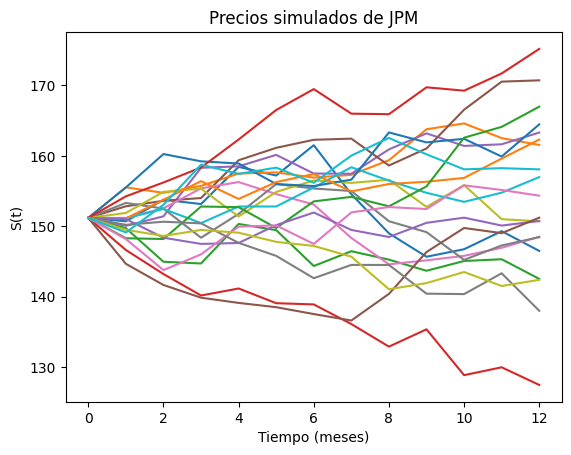

In [10]:
plt.plot(np.transpose(St[0:20,:])) # Sólo se toman las primeras 20 trayectorias simuladas
plt.xlabel("Tiempo (meses)")
plt.title("Precios simulados de JPM")
plt.ylabel("S(t)")
plt.show()

In [11]:
# Calculo de retornos de los precios simulados
precios_sim = pd.DataFrame(np.transpose(St))  # Se transpone la matriz. Cada trayectoria similada es una columna
retornos_sim = np.log(precios_sim/precios_sim.shift(1)).dropna()

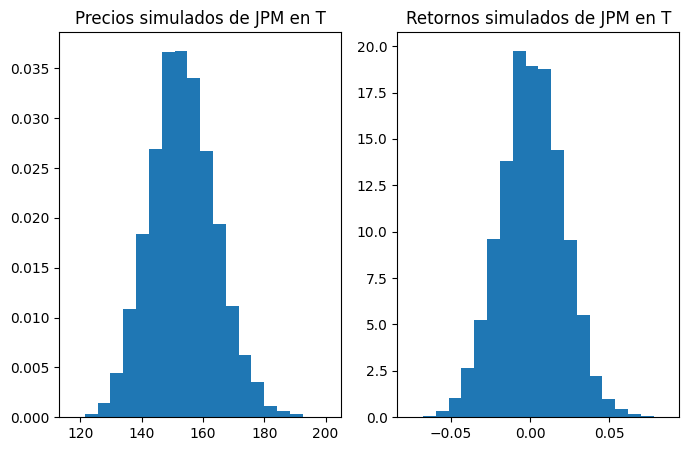

In [12]:
fig = plt.figure(figsize = (8, 5))
plt.subplot(1, 2, 1)
plt.hist(precios_sim.iloc[-1,:],bins=20, density=True)
plt.title("Precios simulados de JPM en T")
plt.subplot(1, 2, 2)
plt.hist(retornos_sim.iloc[-1,:],bins=20, density=True)
plt.title("Retornos simulados de JPM en T")
plt.show()

In [13]:
# Promedio de lo precios simulados 
precios_sim.iloc[-1,:].mean()

153.46352614138814

In [14]:
# Valor esperado
S0 * np.exp(mu_jpm * T) 

153.39292691091694

El valor promedio del precio simulado converge a al calculo de la expectativa formada partir de $S_0$.

In [15]:
# Probabilidad de que retornos < 0
prob = pd.DataFrame(retornos_sim.iloc[-1,:] < 0).value_counts() / NS
prob # Se toman el valor "True" del resultado

12   
False    0.5162
True     0.4838
dtype: float64

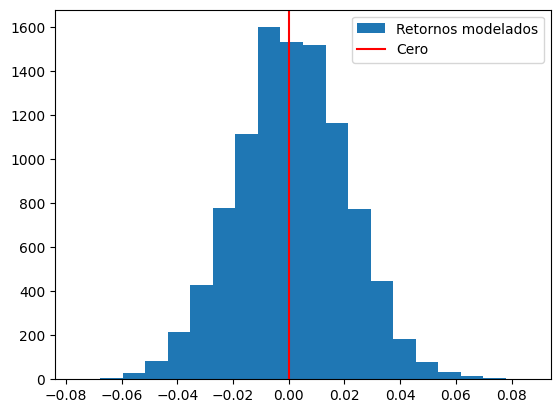

In [16]:
# Distribución de los retornos simulados
plt.hist(retornos_sim.iloc[-1,:], bins=20, label='Retornos modelados')
plt.axvline(0, color='r', label='Cero')
plt.legend()

La probabilidad $0.4783$ corresponde a toda el área calculada a la izquierza del marcador rojo en el histograma.

In [24]:
# Información histórica para AAPL y AMZN
activos = ['JPM', 'MCD', 'META','VZ']
precios = yf.download(activos,start=fechai,end=fechaf,interval=periodicidad)['Adj Close'].dropna()
retornos = np.log(precios/precios.shift(1)).dropna()
mu = retornos.mean()
cov = retornos.cov()
sigma = retornos.std()
n = len(mu)
t = len(retornos)

[*********************100%***********************]  4 of 4 completed


In [25]:
# PMVG - se toma la solución analítica
unos = np.repeat(1,n)
invcov1 = np.linalg.solve(cov,unos) 
wpmvg = (1/(unos @ invcov1)) * invcov1
rpmvg = wpmvg @ mu
sigmapmvg = np.sqrt( wpmvg.T @ cov @ wpmvg)

print('E(Rp): ', round(rpmvg,4))
print('SigmaP: ', round(sigmapmvg,4))

E(Rp):  0.0102
SigmaP:  0.0371


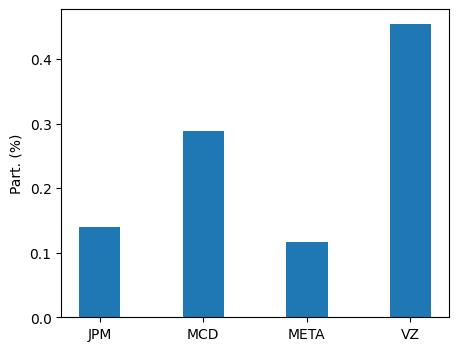

In [26]:
# Pesos del PMVG
fig = plt.figure(figsize = (5, 4))
plt.bar(activos, wpmvg, width = 0.4)
plt.ylabel("Part. (%)")
plt.show()

In [27]:
import scipy.stats
from scipy.stats import norm

In [28]:
# Delta VaR
alpha1 = 0.01
VaRp1 = rpmvg - norm.ppf(1-alpha1)*sigmapmvg
VaRp1

-0.07612400071966637

In [29]:
alpha5 = 0.05
VaRp5 = rpmvg - norm.ppf(1-alpha5)*sigmapmvg
VaRp5

-0.05082612422373044

In [30]:
# Retornos históricos del portafolio
ret_port = retornos @ wpmvg

In [31]:
# VaR Historico
VaRh1 = np.percentile(ret_port,1) # 1 para el 99% de confianza
VaRh1

-0.09206882185970651

In [32]:
VaRh5 = np.percentile(ret_port,5) # 5 para el 95% de confianza
VaRh5

-0.05849985116932965

In [33]:
# Muestra simulada de retornos usando la distribución Normal
n_port = 10000 # Se crean 10.000 aleatorios para el portafolio
ret_sim = np.random.normal(rpmvg,sigmapmvg,n_port)

# Delta VaR al 99%
VaRp1_sim = ret_sim.mean() - norm.ppf(1-alpha1)*ret_sim.std() 
VaRp1_sim

-0.07568041829171468

In [34]:
# Delta VaR al 95%
VaRp5_sim = ret_sim.mean() - norm.ppf(1-alpha5)*ret_sim.std() 
VaRp5_sim

-0.05048849335574087

Se verifica la convergencia de los calculos del VaR al 99% y al 95% del modelo Delta VaR. Tambien se puede obtener un resultado analogo usando la distribución normal multivariada para generar las muestras simuladas de retornos para los activos. 